In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

!pip install contractions
import contractions

     |████████████████████████████████| 321 kB 4.0 MB/s 
     |████████████████████████████████| 284 kB 36.4 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85448 sha256=15c290a44c2bdef187f601fecb4298f404a110dafea98052418ea9a66fc016b0
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [4]:
from google.colab import files
uploaded = files.upload()

Saving Sarcasm_Headlines_Dataset_v2.json to Sarcasm_Headlines_Dataset_v2.json


Chargement du fichier json

In [5]:
import io
df_train= pd.read_json(io.BytesIO(uploaded['Sarcasm_Headlines_Dataset_v2.json']),lines=True)

In [6]:
df_train.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [7]:
df_train["len"]= df_train["headline"].apply(lambda x : len(x))

Prétraitement

In [19]:
import re
df_train["headline"]=df_train["headline"].apply(lambda x: x.lower())
df_train["headline"]=df_train["headline"].apply(lambda x: contractions.fix(x))
df_train["headline"]=df_train["headline"].apply(lambda x: re.sub('(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)',' ', x))

In [9]:
import nltk
nltk.download('wordnet')

def stemming(corpus):
    
    corpus_=""
    
    ps = nltk.stem.porter.PorterStemmer()
    for mot in corpus.split():
        corpus_=corpus_ + " " + ps.stem(mot) + " "
        
    return corpus_

def lemmatisation(corpus):
    corpus_=""
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    for mot in corpus.split():
        corpus_=corpus_ + " " + lem.lemmatize(mot) + " "
    return corpus_

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [10]:
df_train["headline"]=df_train["headline"].apply(lambda x: stemming(x))
df_train["headline"]=df_train["headline"].apply(lambda x: lemmatisation(x))

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_features = 5000
trunc_type = 'post'
padding_type = 'post'
tokenizer = Tokenizer(num_words=max_features,oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['headline'])
word_index = tokenizer.word_index
list_tokenized_train = tokenizer.texts_to_sequences(df_train['headline'])

maxlen = 100
X = pad_sequences(list_tokenized_train, maxlen=maxlen,truncating=trunc_type,padding="post")
Y = df_train['is_sarcastic']

In [27]:
embeddings_index = {}
GLOVE_DIR="glove.6B.100d.txt"
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(22895, 100) (22895,)
(5724, 100) (5724,)


Modélisation

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional,GlobalMaxPool1D,Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(len(word_index)+1, 100,weights=[embedding_matrix]))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100,dropout=0.5,recurrent_dropout=0.5)))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 100)         2430200   
                                                                 
 dropout_12 (Dropout)        (None, None, 100)         0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 201       
                                                                 
Total params: 2,591,201
Trainable params: 2,591,201
Non-trainable params: 0
____________________________________________

In [32]:
epochs = 10
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
322/322 [==============================] - 356s 1s/step - loss: 0.6443 - accuracy: 0.6109 - val_loss: 0.5028 - val_accuracy: 0.7480
Epoch 2/10
322/322 [==============================] - 349s 1s/step - loss: 0.5085 - accuracy: 0.7469 - val_loss: 0.3972 - val_accuracy: 0.8092
Epoch 3/10
322/322 [==============================] - 350s 1s/step - loss: 0.4453 - accuracy: 0.7880 - val_loss: 0.3670 - val_accuracy: 0.8266
Epoch 4/10
322/322 [==============================] - 349s 1s/step - loss: 0.4018 - accuracy: 0.8178 - val_loss: 0.3661 - val_accuracy: 0.8367
Epoch 5/10
322/322 [==============================] - 350s 1s/step - loss: 0.3791 - accuracy: 0.8305 - val_loss: 0.3547 - val_accuracy: 0.8328
Epoch 6/10
322/322 [==============================] - 350s 1s/step - loss: 0.3478 - accuracy: 0.8476 - val_loss: 0.3489 - val_accuracy: 0.8432
Epoch 7/10
322/322 [==============================] - 348s 1s/step - loss: 0.3302 - accuracy: 0.8556 - val_loss: 0.3373 - val_accuracy: 0.8441

Evaluation

In [33]:
model.evaluate(X_test,y_test)

179/179 [==============================] - 11s 64ms/step - loss: 0.3252 - accuracy: 0.8604


[0.32524022459983826, 0.8604122996330261]

In [34]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    
    """
    
    Plot loss and accuracy in order to see if we observe an overfitting
    
    """
    figure = plt.figure(figsize=(10,10))

    # accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'go--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'yo--', label = "val acc")
    
    plt.title("train_acc vs val_acc")
    
   
    #names axis
    plt.xlabel("epcs")
    plt.ylabel("acc")
    plt.legend()

    # loss
    plt.subplot(222)
    plt.plot(history.history['loss'],'go--', label = "loss")
    plt.plot(history.history['val_loss'], 'yo--', label = "val_loss")
    
    plt.title("train_loss vs val_loss")
    
    #names axis
    plt.ylabel("loss")
    plt.xlabel("epcs")

    plt.legend()
    plt.show()
    

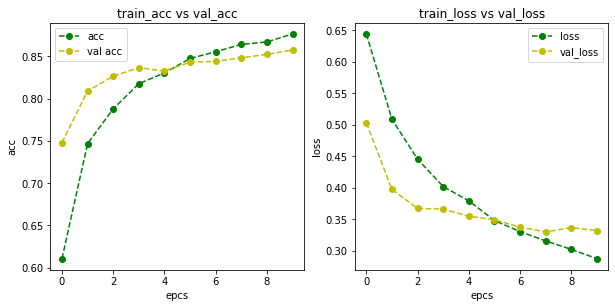

In [35]:
plot_loss_and_accuracy(history)